# Problem Setting: Bayesian Mixed Media Model (MMM) for Marketing Attribution

## Objective

Given weekly revenue and multi-channel marketing spend data, develop a fully probabilistic Bayesian Mixed Media Model (MMM) to quantify and compare the sales effectiveness of different marketing channels. The goal is to optimize budget allocation by robustly estimating both the incremental contribution and the return on investment (ROI) of each channel, while accounting for carry-over, saturation, and uncertainty.

## Formal Definition

- **Problem Statement**  
  Quantify the individual and joint contributions of multiple marketing channels to weekly sales using a Bayesian hierarchical model. The model incorporates adstock (carry-over) effects, trend, and seasonality to capture both immediate and lagged impacts of spend.

- **Learning Task**  
  Bayesian regression using hierarchical priors and latent variables for:
    - Parameter inference (channel coefficients, adstock/decay, saturation effects, controls)
    - Full posterior uncertainty quantification and credible intervals for explainability.

- **Input Attributes (Features)**
    - `X`: matrix of weekly (per-channel) marketing spend
        - spend_channel_1, spend_channel_2, ..., spend_channel_7
        - **Adstock transformation:**
            \[
            A_{t,m} = spend_{t,m} + \lambda_m \times A_{t-1,m}
            \]
            Where \(\lambda_m\) is the estimated channel-specific decay rate.
        - **Saturation:** captured through non-linear functional forms per channel.
        - **Time controls:**  
            - `trend` (captures gradual growth or decay)
            - `seasonality` (captures cyclical or recurring patterns)

- **Target Variable (Label)**
    - Weekly sales revenue \( y_t \) as a function of adstocked channel spend, trend, seasonality, and noise.

- **Model Components**
    - Channel coefficients \( \beta_m \) (efficacy/effectiveness per channel)
    - Decay/adstock rates \( \lambda_m \) (carry-over effect per channel)
    - Saturation parameters (non-linear channel response)
    - Baseline/intercept \( \alpha \) (base sales not attributable to marketing)
    - Controls for trend/seasonality
    - Observation noise \( \epsilon_t \), capturing unexplained factors

- **Posterior Inference**
    - Each parameter is estimated as a full posterior distribution using MCMC.
    - Weakly informative, domain-based priors ensure regularization and interpretability.

- **Evaluation**
    - **Model fit:** evaluated by posterior predictive checks and RMSE/MAE on the (unscaled) sales.
    - **Uncertainty calibration:** verified by fraction of observations within credible intervals.
    - **Channel contribution:**
        - Posterior mean and credible intervals for the total (and per-period) sales contributed by each channel.
        - Visualization of channel contributions over time.
    - **ROI estimation:**
        - Posterior mean ROI per channel (revenue per unit of spend), with interpretation and ranking to guide optimal budget allocation.
    - **Insights:**
        - Model outputs guide data-driven reallocation of marketing budget toward channels with high ROI and incremental impact.
        - Quantified uncertainties assist in risk-aware decision-making.


## Importing libraries

In [1]:
pip install pymc_marketing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.1/359.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.4/252.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires numba<0

In [71]:
import pandas as pd
import numpy as np
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_extras.prior import Prior
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Loading Data

In [3]:
df = pd.read_csv("data/MMM_test_data.csv")

In [4]:
df.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [5]:
cols = df.columns.tolist()
print(cols)

['start_of_week', 'revenue', 'spend_channel_1', 'spend_channel_2', 'spend_channel_3', 'spend_channel_4', 'spend_channel_5', 'spend_channel_6', 'spend_channel_7']


In [6]:
print("The shape of the dataframe is", df.shape)

The shape of the dataframe is (104, 9)


In [7]:
print("The information about dataframe is ", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_of_week    104 non-null    object 
 1   revenue          104 non-null    float64
 2   spend_channel_1  104 non-null    float64
 3   spend_channel_2  104 non-null    float64
 4   spend_channel_3  104 non-null    float64
 5   spend_channel_4  104 non-null    float64
 6   spend_channel_5  104 non-null    float64
 7   spend_channel_6  104 non-null    float64
 8   spend_channel_7  104 non-null    float64
dtypes: float64(8), object(1)
memory usage: 7.4+ KB
The information about dataframe is  None


In [8]:
if "start_of_week" in cols:
    df["start_of_week"] = pd.to_datetime(df["start_of_week"], format="%d-%m-%y", errors="raise")
    df = df.sort_values("start_of_week").reset_index(drop=True)

In [9]:
df.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [10]:
# Basic statistics
print("Summary Statistics:")
df.describe()


Summary Statistics:


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
count,104,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,2021-08-25 12:00:00,136490.190673,1245.604808,343.640962,19507.177981,6915.136731,8575.611442,5063.699038,27701.367404
min,2020-08-30 00:00:00,63207.090000,0.000000,4.370000,5938.130000,3602.200000,747.460000,0.000000,9391.210000
25%,2021-02-26 06:00:00,101675.685000,334.275000,120.470000,13879.000000,5113.937500,2902.032500,0.000000,19797.710000
50%,2021-08-25 12:00:00,128790.460000,856.870000,202.020000,17929.450000,6194.400000,6879.270000,2423.095000,24248.640000
75%,2022-02-21 18:00:00,157707.280000,1658.032500,553.075000,22252.262500,7470.557500,14367.582500,8701.960000,33852.652500
max,2022-08-21 00:00:00,418186.380000,8513.830000,1605.850000,49689.380000,22629.690000,33009.650000,33692.830000,77488.420000
std,NaN,50810.253012,1388.384632,332.988218,8714.759886,3123.172035,6956.787524,6689.472660,12176.293684


## Missing Values Check

In [11]:
# Check columns with missing values and count how many missing in each
missing_counts = df.isna().sum()
print("Columns with missing values: ")
print(missing_counts[missing_counts > 0])

Columns with missing values: 
Series([], dtype: int64)


## Visualizations

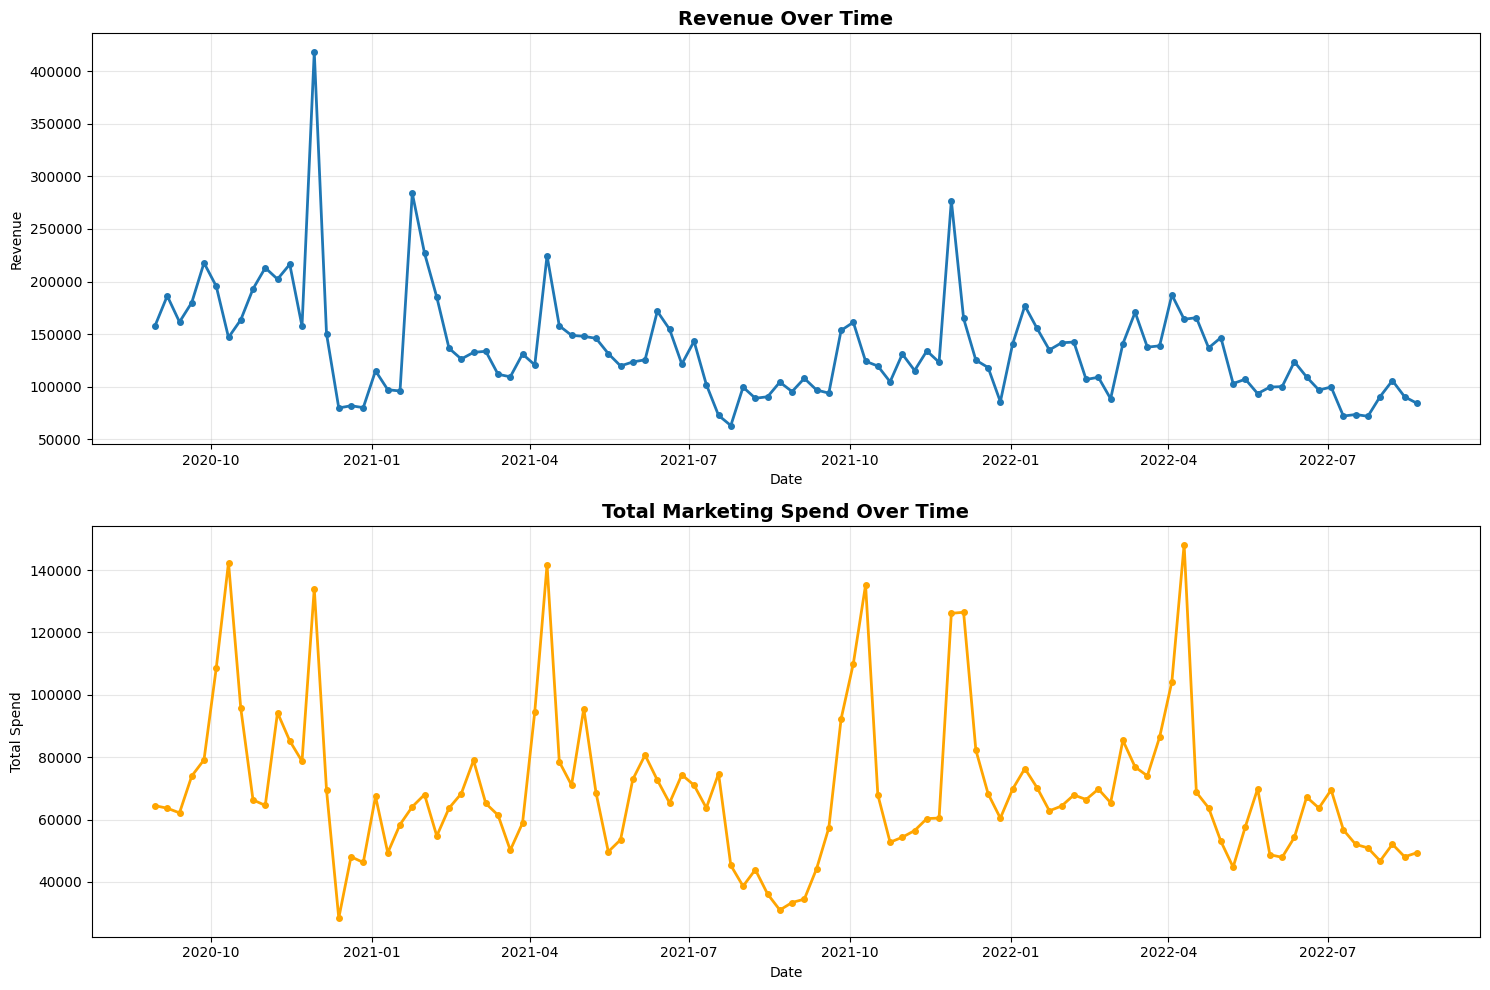

In [12]:
# Visualize revenue over time
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Revenue over time
axes[0].plot(df['start_of_week'], df['revenue'], marker='o', linewidth=2, markersize=4)
axes[0].set_title('Revenue Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenue')
axes[0].grid(True, alpha=0.3)

# Total spend over time
spend_cols = [col for col in df.columns if 'spend_channel' in col]
df['total_spend'] = df[spend_cols].sum(axis=1)
axes[1].plot(df['start_of_week'], df['total_spend'], marker='o', linewidth=2, markersize=4, color='orange')
axes[1].set_title('Total Marketing Spend Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Spend')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


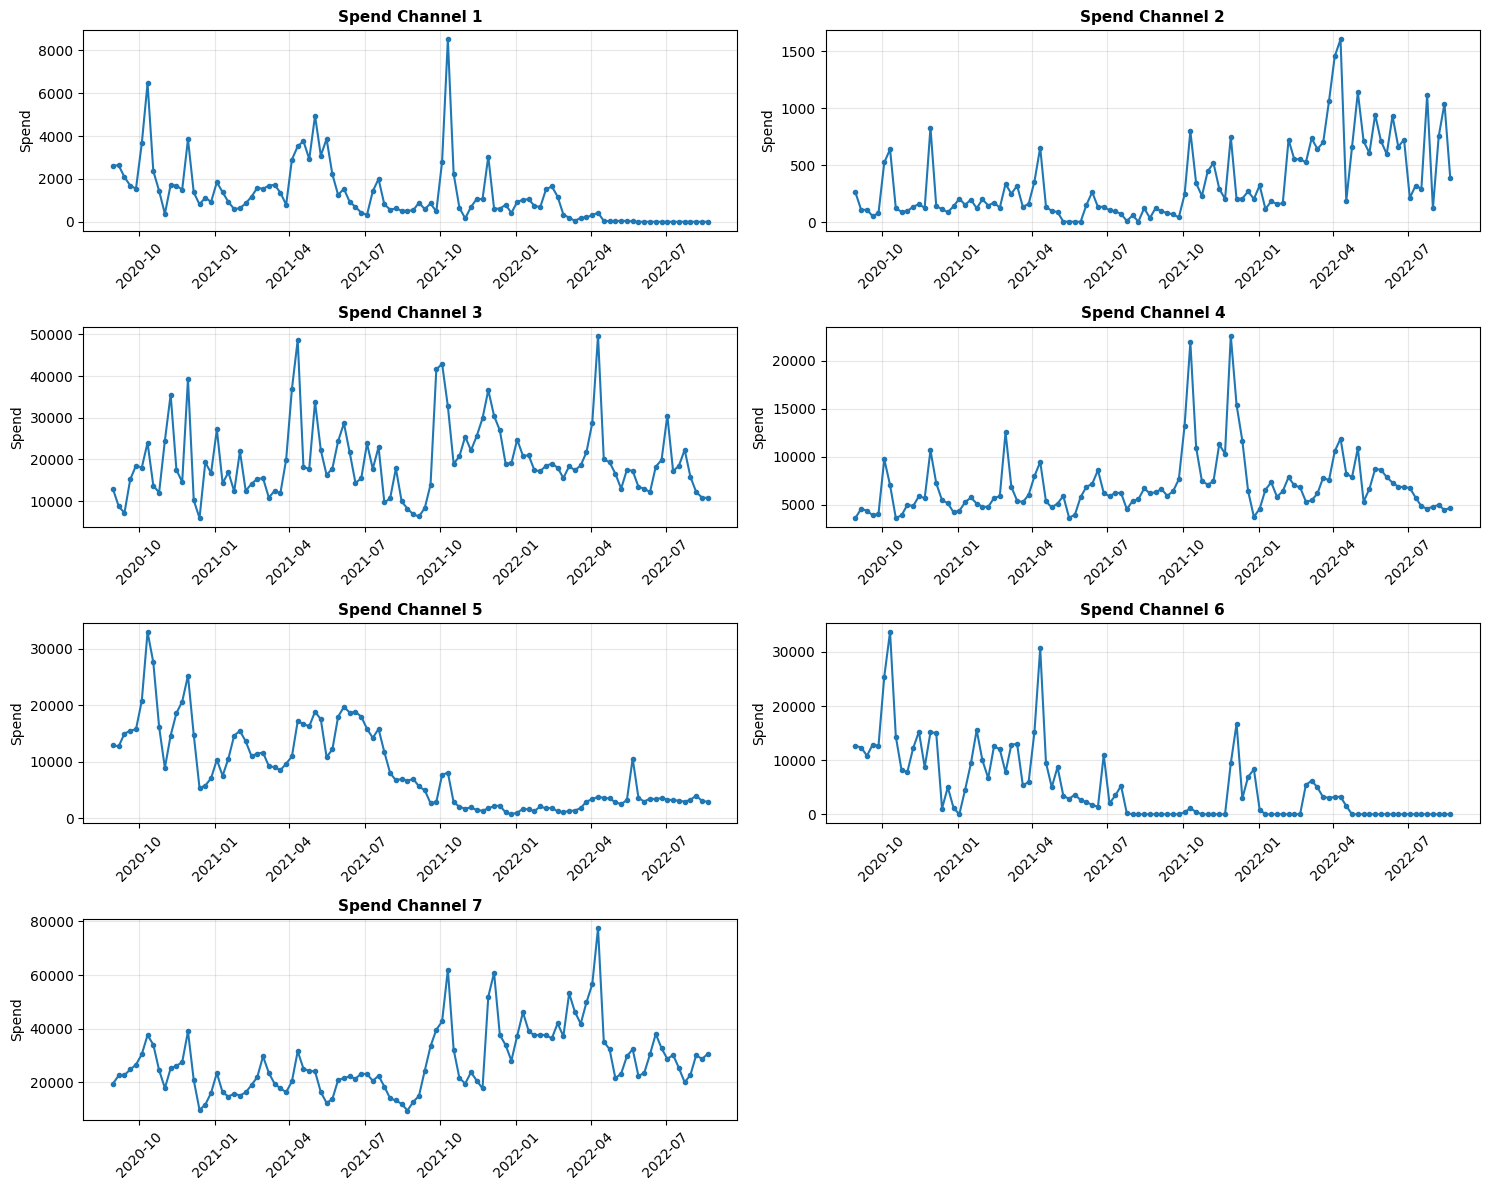

In [13]:
# Visualize individual channel spends
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(spend_cols):
    axes[i].plot(df['start_of_week'], df[col], marker='o', linewidth=1.5, markersize=3)
    axes[i].set_title(f'{col.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Spend')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

# Remove the last empty subplot
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()


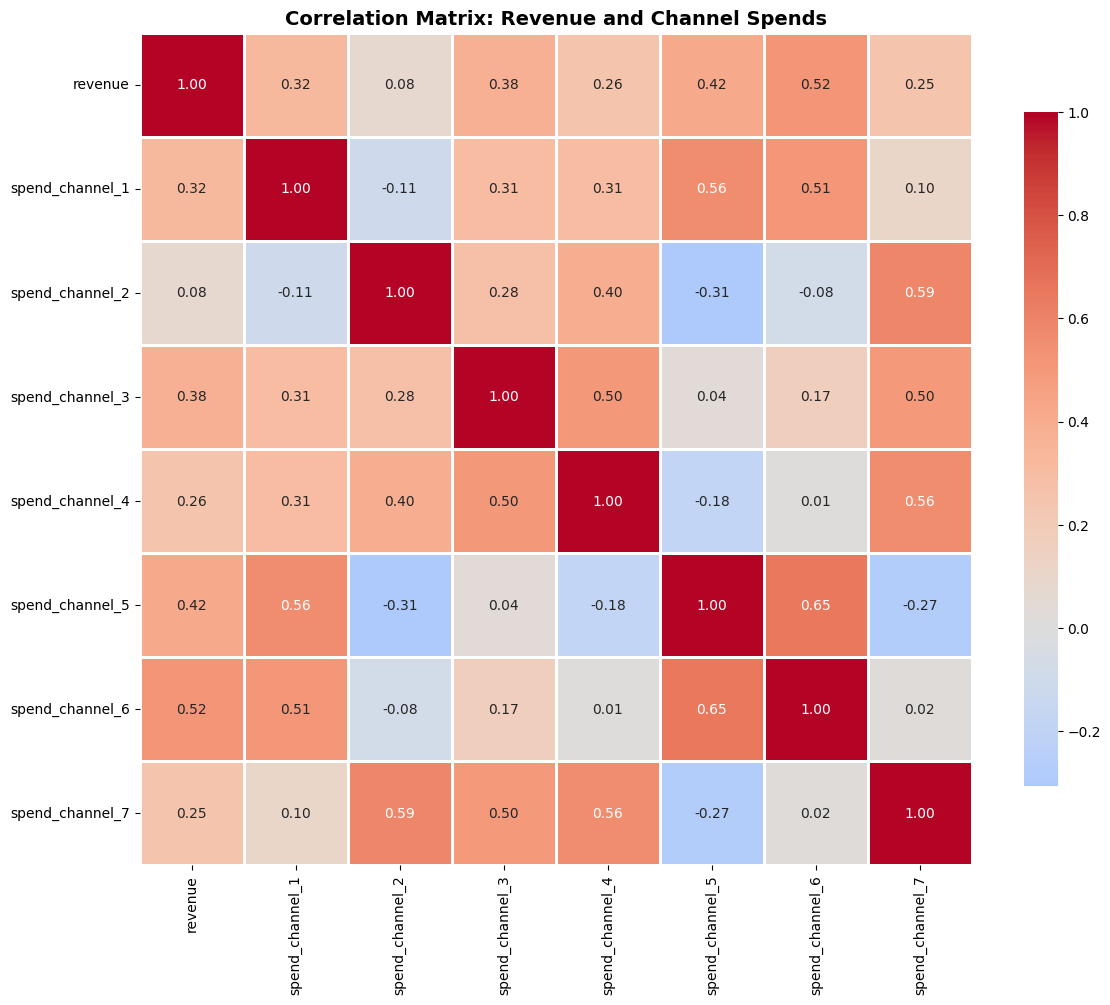


Correlation with Revenue (sorted):
revenue            1.000000
spend_channel_6    0.522644
spend_channel_5    0.421304
spend_channel_3    0.381686
spend_channel_1    0.323828
spend_channel_4    0.255698
spend_channel_7    0.249895
spend_channel_2    0.080848
Name: revenue, dtype: float64


In [14]:
# Correlation analysis
fig, ax = plt.subplots(figsize=(12, 10))
correlation_cols = ['revenue'] + spend_cols
corr_matrix = df[correlation_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix: Revenue and Channel Spends', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation with Revenue (sorted):")
print(corr_matrix['revenue'].sort_values(ascending=False))


In [15]:
totalspend = df[
    ['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
     'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
     'spend_channel_7']
].sum().sum()

In [16]:
total_revenue = df['revenue'].sum()
print(total_revenue)

14194979.830000002


In [17]:
roi = total_revenue / totalspend
print(roi)

1.9680718876580992


€1.968 in revenue for every €1 spent.

## Trend and Seasonality

In [18]:
df.rename(columns={"start_of_week": "date"}, inplace=True)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["dayofyear"] = df["date"].dt.dayofyear
df2 = df.copy()
df["trend"] = np.arange(len(df), dtype=float)

# Annual seasonality via Fourier terms (weekly period 52)
period = 52.0
week = df2["date"].dt.isocalendar().week.astype(int)

df2["sin1"] = np.sin(2 * np.pi * 1 * week / period)
df2["cos1"] = np.cos(2 * np.pi * 1 * week / period)
df2["sin2"] = np.sin(2 * np.pi * 2 * week / period)
df2["cos2"] = np.cos(2 * np.pi * 2 * week / period)

# Composite seasonality (weighted sum of first two harmonics)
df["seasonality"] = df2["sin1"] + df2["cos1"] + 0.5 * (df2["sin2"] + df2["cos2"])

df.head()

,date,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,total_spend,year,month,dayofyear,trend,seasonality
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,64446.14,2020,8,243,0.0,-1.222720
1,2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,63622.88,2020,9,250,1.0,-1.332315
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,62138.39,2020,9,257,2.0,-1.420624
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,73952.48,2020,9,264,3.0,-1.479059
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,79146.77,2020,9,271,4.0,-1.500000


In [19]:
df_final = df[[
    'date',
    'revenue',
    'spend_channel_1',
    'spend_channel_2',
    'spend_channel_3',
    'spend_channel_4',
    'spend_channel_5',
    'spend_channel_6',
    'spend_channel_7',
    'trend',
    'seasonality',
    'year',
    'month',
    'dayofyear',
]]

In [20]:
channels = [f"spend_channel_{i}" for i in range(1, 8)]
df_mmm = df_final.rename(columns={"revenue": "y"}).copy()

eps = 1e-6
for c in channels:
    df_mmm[c] = df_mmm[c].astype(float) + eps

for col in ["trend", "seasonality"]:
    s = df_mmm[col].std()
    if s and s > 0:
        df_mmm[col] = (df_mmm[col] - df_mmm[col].mean()) / s

# 1) Compute spend-proportion weights
totals = df_mmm[channels].sum(axis=0).to_numpy(float)
weights = totals / totals.sum()

# 2) Priors (broadcasted across channels)
mu_y, sd_y = df_mmm["y"].mean(), max(df_mmm["y"].std(), 1.0)

from pymc_extras.prior import Prior

model_config = {
    "intercept": Prior("Normal", mu=mu_y, sigma=2 * sd_y),  # level prior
    "sigma": Prior("HalfNormal", sigma=sd_y),               # obs noise

    # Channel coefficients: HalfNormal scaled by spend share (broadcasts dims='channel')
    "beta_channel": Prior("HalfNormal", sigma=(1.0 * len(channels) * weights), dims="channel"),

    # Adstock decay (0..1) and saturation scale per channel (using your requested names)
    "adstock_alpha": Prior("Beta", alpha=2.0, beta=2.0, dims="channel"),     # carry-over
    "saturation_lam": Prior("Gamma", alpha=3.0, beta=1.0, dims="channel"),   # saturation scale
    "saturation_beta": Prior("HalfNormal", sigma=2.0, dims="channel"),       # saturation, positive

    # Controls
    "trend_coef": Prior("Normal", mu=0.0, sigma=1.0),         # trend control
    "seasonality_coef": Prior("Normal", mu=0.0, sigma=1.0),   # seasonality
}

adstock = GeometricAdstock(l_max=8)
saturation = LogisticSaturation()


In [21]:
sampler_config = {
    "cores": 8,
    "progressbar": True,
    "init": "adapt_diag",
    "target_accept": 0.95,
}

In [22]:
mmm = MMM(
    date_column="date",
    channel_columns=channels,
    adstock=adstock,
    saturation=saturation,
    control_columns=["trend", "seasonality"],
    model_config=model_config,
    sampler_config=sampler_config,
)


In [23]:
mmm.model_config

{'intercept': Prior("Normal", mu=136490.19067307696, sigma=101620.50602460845),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=2.0, beta=2.0, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3.0, beta=1.0, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2.0, dims="channel"),
 'sigma': Prior("HalfNormal", sigma=50810.25301230422),
 'beta_channel': Prior("HalfNormal", sigma=[0.1257239  0.03468506 1.96893783 0.69797253 0.86557091 0.51109948
  2.79601029], dims="channel"),
 'trend_coef': Prior("Normal", mu=0.0, sigma=1.0),
 'seasonality_coef': Prior("Normal", mu=0.0, sigma=1.0)}

In [24]:
X=df_mmm.drop(columns=["y"])
y=df_mmm["y"]

In [25]:
mmm.build_model(X, y)

In [26]:
idata_prior = mmm.sample_prior_predictive(X, y)

In [27]:
trace = mmm.fit(X, y)
mmm.save("model/mmm_model.pkl")

Output()

ERROR:pymc.stats.convergence:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Output()

In [28]:
mmm.idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

In [29]:
fig=mmm.graphviz()

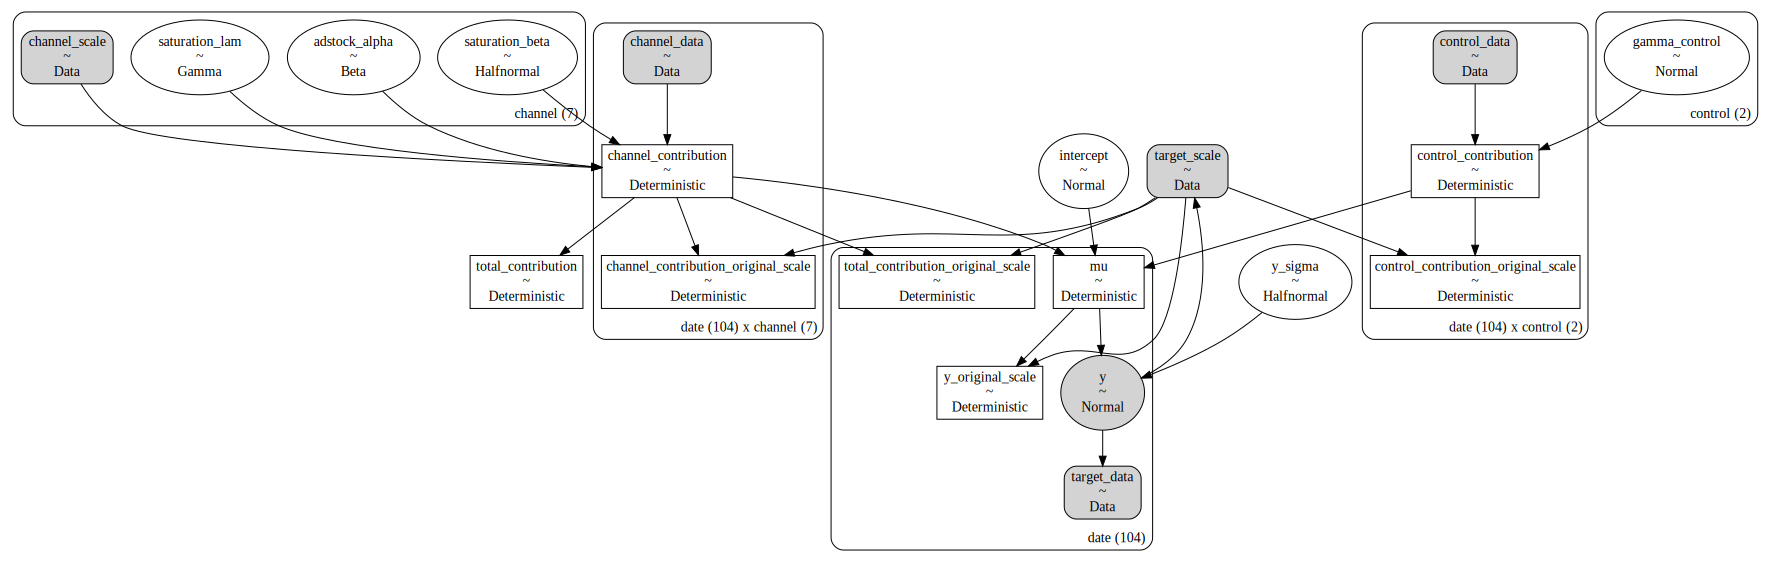

In [30]:
fig

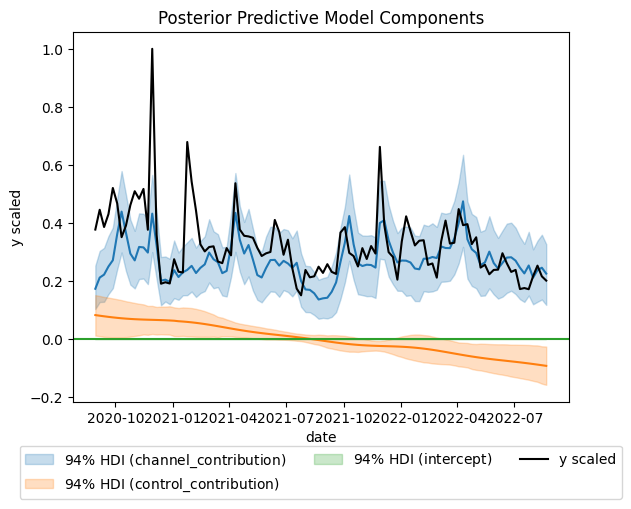

In [31]:
fig = mmm.plot_components_contributions()

## Return on Adspend

In [32]:
get_mean_contributions = mmm.compute_mean_contributions_over_time(original_scale=True)
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

In [33]:
roas_samples = (
    channel_contribution_original_scale
        .stack(sample=("chain", "draw")).sum("date")
        / X[["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]].sum().to_numpy()[..., None]
)

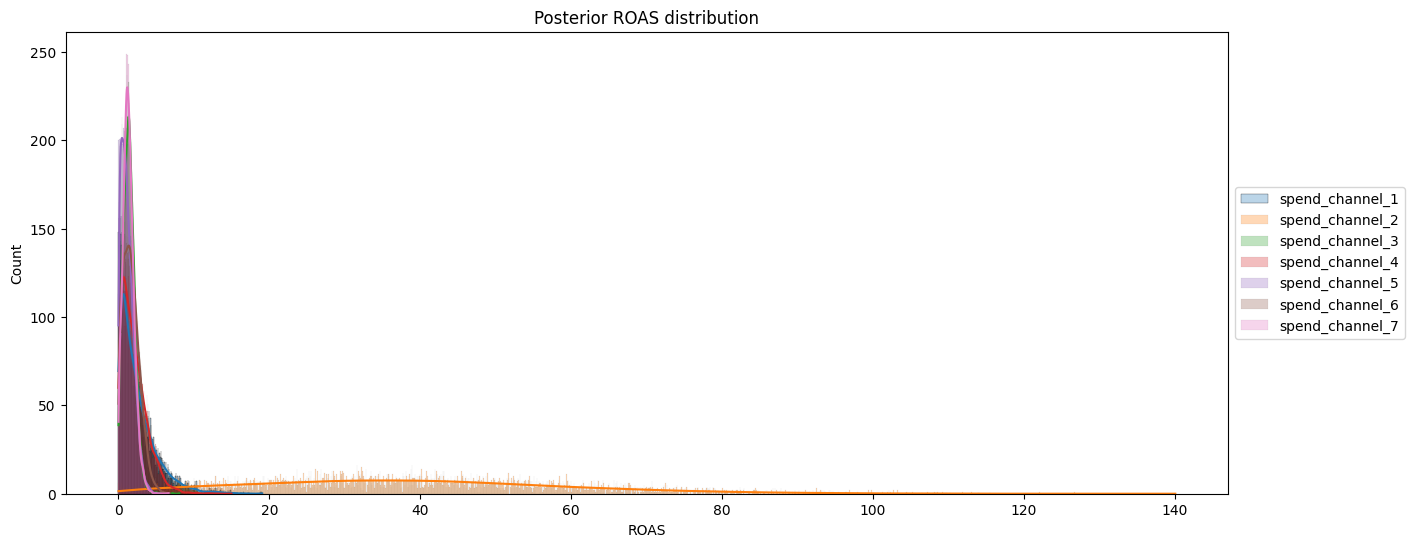

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
for channel in ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]:
    sns.histplot(
        roas_samples.sel(channel=channel).to_numpy(),
        binwidth=0.05, alpha=0.3, kde=True, ax=ax,
        legend=True, label=channel
    )

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS")
fig

# ROAS Summary
roas_df = roas_samples.to_dataframe(name="roas")

In [35]:
roas_df.groupby("channel").mean()

,roas
channel,
spend_channel_1,2.510905
spend_channel_2,38.175683
spend_channel_3,1.388331
spend_channel_4,2.106553
spend_channel_5,1.162673
spend_channel_6,1.689538
spend_channel_7,1.346582


In [36]:
mmm.idata["sample_stats"]["diverging"].sum().item()

1

In [37]:
summary = az.summary(trace)
print(summary)

                                                      mean         sd  \
adstock_alpha[spend_channel_1]                       0.542      0.236   
adstock_alpha[spend_channel_2]                       0.433      0.223   
adstock_alpha[spend_channel_3]                       0.359      0.206   
adstock_alpha[spend_channel_4]                       0.392      0.235   
adstock_alpha[spend_channel_5]                       0.410      0.212   
...                                                    ...        ...   
y_original_scale[2022-07-24T00:00:00.000000000]  94069.911  13501.353   
y_original_scale[2022-07-31T00:00:00.000000000]  75743.989  11216.530   
y_original_scale[2022-08-07T00:00:00.000000000]  85611.138  10443.793   
y_original_scale[2022-08-14T00:00:00.000000000]  88262.109  12254.514   
y_original_scale[2022-08-21T00:00:00.000000000]  78880.643  11458.551   

                                                    hdi_3%     hdi_97%  \
adstock_alpha[spend_channel_1]                   

R-hat diagnostics:
adstock_alpha[spend_channel_1]                     1.0
adstock_alpha[spend_channel_2]                     1.0
adstock_alpha[spend_channel_3]                     1.0
adstock_alpha[spend_channel_4]                     1.0
adstock_alpha[spend_channel_5]                     1.0
                                                  ... 
y_original_scale[2022-07-24T00:00:00.000000000]    1.0
y_original_scale[2022-07-31T00:00:00.000000000]    1.0
y_original_scale[2022-08-07T00:00:00.000000000]    1.0
y_original_scale[2022-08-14T00:00:00.000000000]    1.0
y_original_scale[2022-08-21T00:00:00.000000000]    1.0
Name: r_hat, Length: 2210, dtype: float64


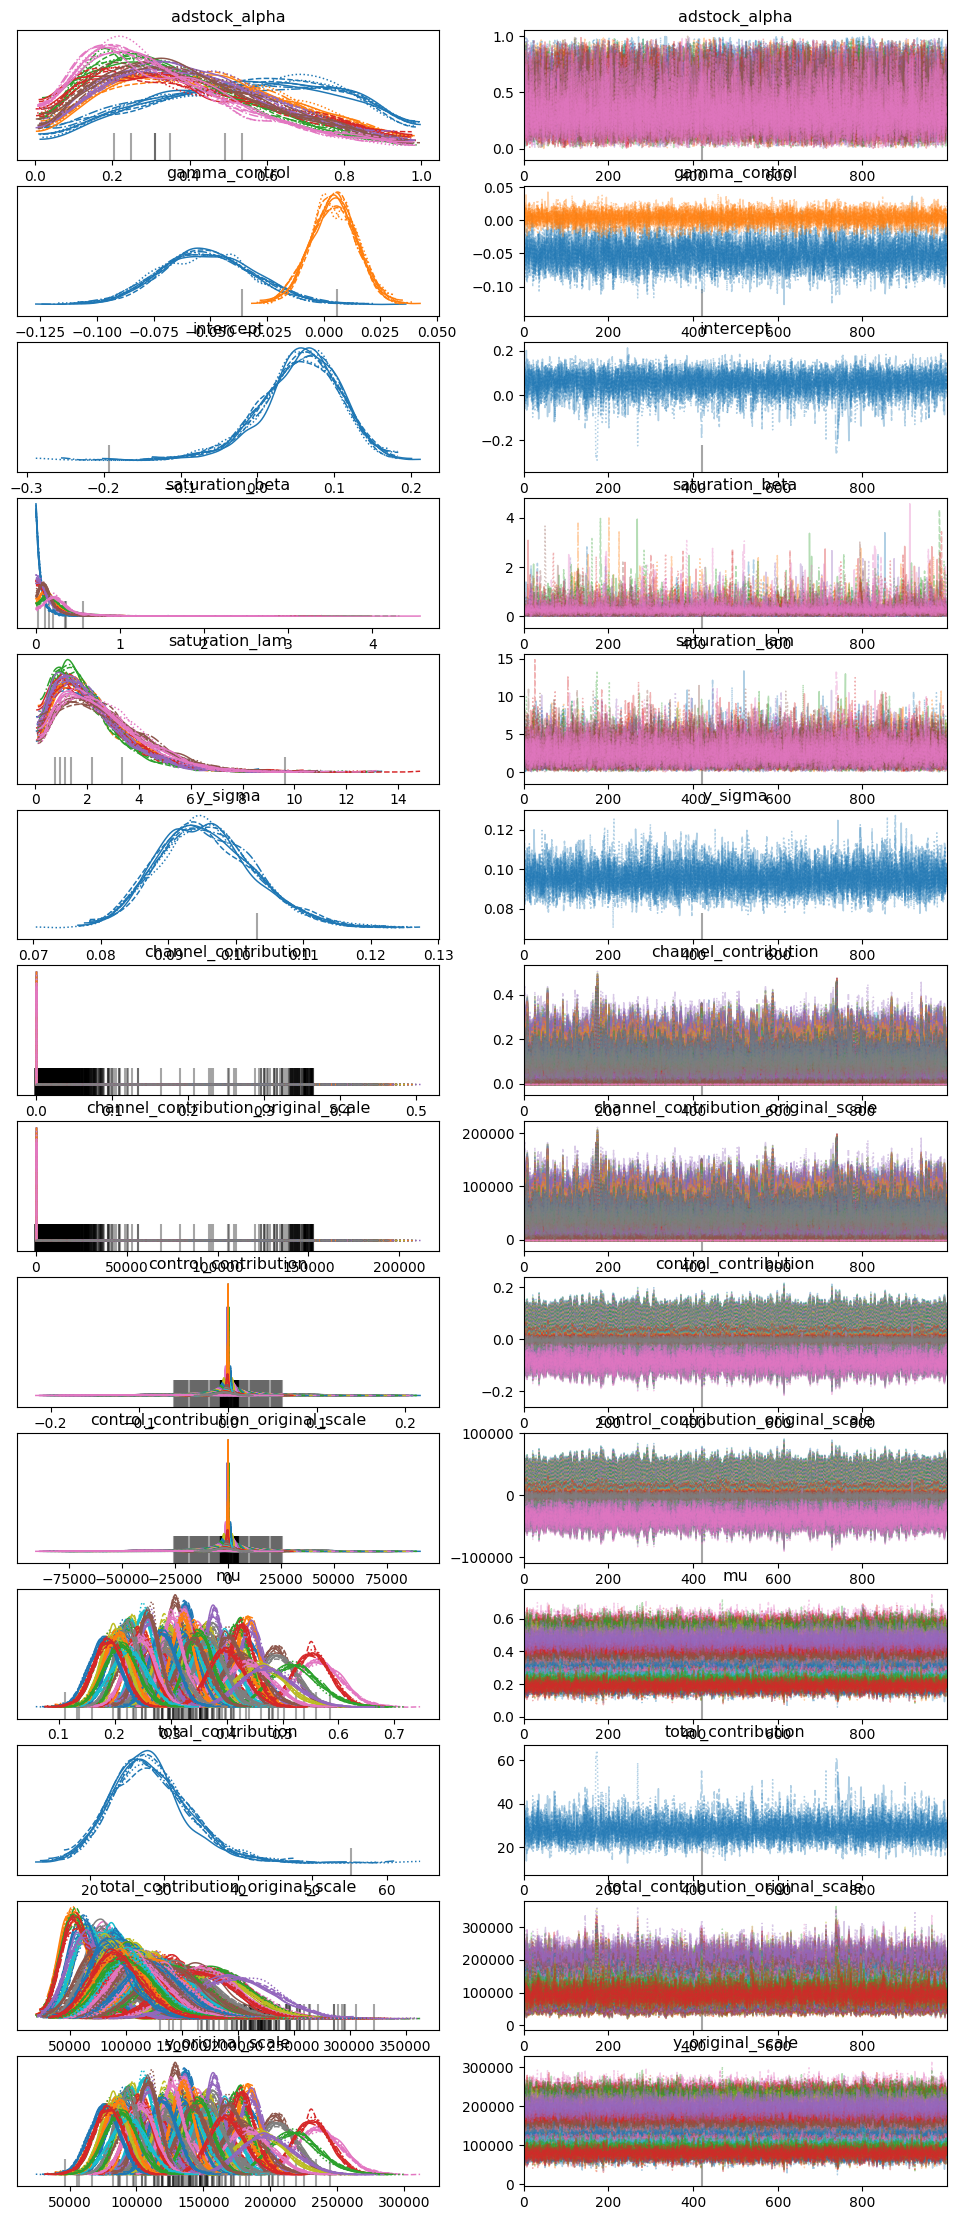

In [38]:
# Check R-hat values for convergence; values close to 1 indicate good mixing
print("R-hat diagnostics:")
print(summary['r_hat'])

# Plot the trace and posterior distributions for inspection
az.plot_trace(trace)
plt.show()

In [40]:
divergences = mmm.idata["sample_stats"]["diverging"].sum().item()
print(f"Number of divergent transitions: {divergences}")

Number of divergent transitions: 1


In [41]:
print(trace.posterior.data_vars)

Data variables:
    adstock_alpha                        (chain, draw, channel) float64 448kB ...
    gamma_control                        (chain, draw, control) float64 128kB ...
    intercept                            (chain, draw) float64 64kB 0.0433 .....
    saturation_beta                      (chain, draw, channel) float64 448kB ...
    saturation_lam                       (chain, draw, channel) float64 448kB ...
    y_sigma                              (chain, draw) float64 64kB 0.08934 ....
    channel_contribution                 (chain, draw, date, channel) float64 47MB ...
    channel_contribution_original_scale  (chain, draw, date, channel) float64 47MB ...
    control_contribution                 (chain, draw, date, control) float64 13MB ...
    control_contribution_original_scale  (chain, draw, date, control) float64 13MB ...
    mu                                   (chain, draw, date) float64 7MB 0.29...
    total_contribution                   (chain, draw) float64 64

In [42]:
channel_contrib_sum = trace.posterior['channel_contribution_original_scale'].sum(dim='date').mean(dim=['chain', 'draw']).values

In [43]:
total_spends = df_mmm[channels].sum()

In [44]:
roi = channel_contrib_sum / total_spends.values

In [45]:
for i, ch in enumerate(channels):
    print(f"Channel: {ch}, Contribution: {channel_contrib_sum[i]:.2f}, Spend: {total_spends[i]:.2f}, ROI: {roi[i]:.4f}")

Channel: spend_channel_1, Contribution: 325269.89, Spend: 129542.90, ROI: 2.5109
Channel: spend_channel_2, Contribution: 1364347.76, Spend: 35738.66, ROI: 38.1757
Channel: spend_channel_3, Contribution: 2816572.25, Spend: 2028746.51, ROI: 1.3883
Channel: spend_channel_4, Contribution: 1514978.75, Spend: 719174.22, ROI: 2.1066
Channel: spend_channel_5, Contribution: 1036946.07, Spend: 891863.59, ROI: 1.1627
Channel: spend_channel_6, Contribution: 889752.34, Spend: 526624.70, ROI: 1.6895
Channel: spend_channel_7, Contribution: 3879424.08, Spend: 2880942.21, ROI: 1.3466


/tmp/ipython-input-2722061090.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Channel: {ch}, Contribution: {channel_contrib_sum[i]:.2f}, Spend: {total_spends[i]:.2f}, ROI: {roi[i]:.4f}")


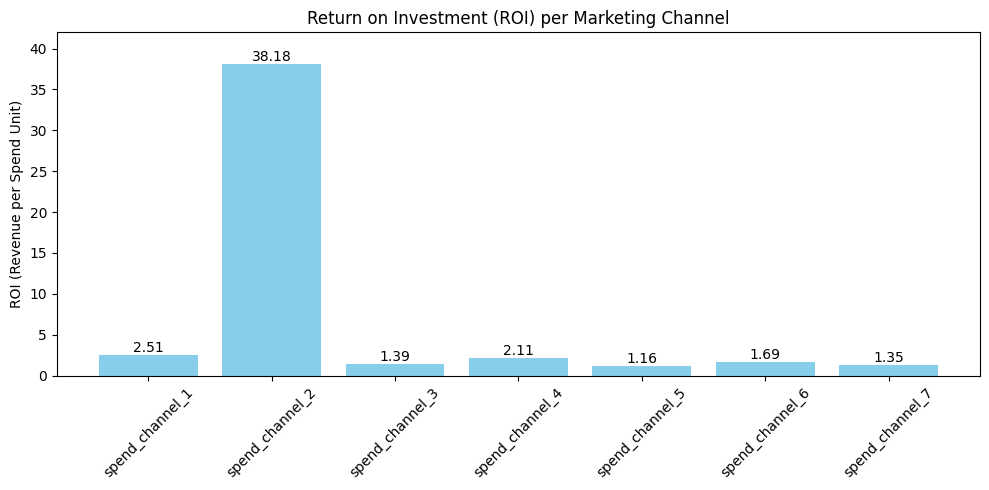

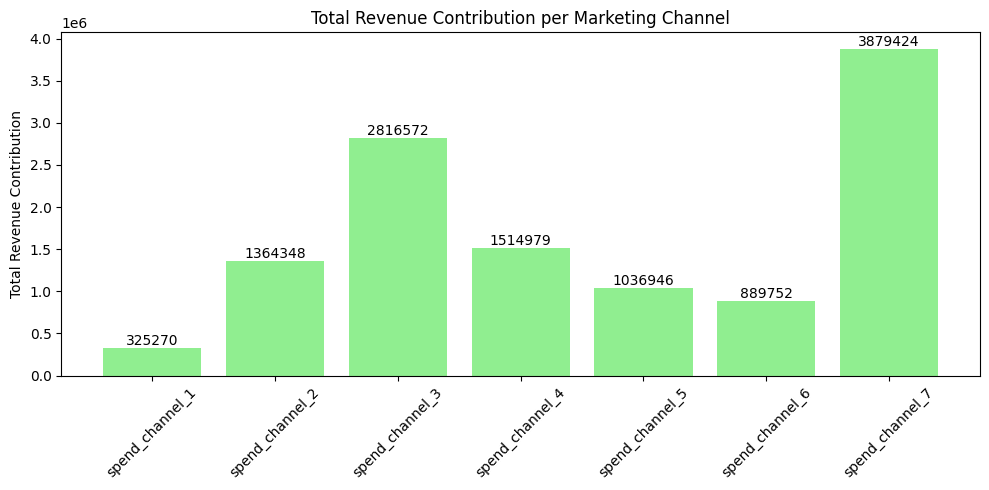

In [46]:
plt.figure(figsize=(10, 5))
bars = plt.bar(channels, roi, color='skyblue')
plt.ylabel('ROI (Revenue per Spend Unit)')
plt.title('Return on Investment (ROI) per Marketing Channel')
plt.xticks(rotation=45)
plt.ylim(0, max(roi)*1.1)

# Annotate bars with ROI values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Bar chart for total revenue contributions per channel
plt.figure(figsize=(10, 5))
bars = plt.bar(channels, channel_contrib_sum, color='lightgreen')
plt.ylabel('Total Revenue Contribution')
plt.title('Total Revenue Contribution per Marketing Channel')
plt.xticks(rotation=45)

# Annotate bars with contribution values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [61]:
print('Parameters in trace.prior:', list(trace.prior.data_vars))
print('Parameters in trace.posterior:', list(trace.posterior.data_vars))

Parameters in trace.prior: ['adstock_alpha', 'channel_contribution', 'channel_contribution_original_scale', 'control_contribution', 'control_contribution_original_scale', 'gamma_control', 'intercept', 'mu', 'saturation_beta', 'saturation_lam', 'total_contribution', 'total_contribution_original_scale', 'y_original_scale', 'y_sigma']
Parameters in trace.posterior: ['adstock_alpha', 'gamma_control', 'intercept', 'saturation_beta', 'saturation_lam', 'y_sigma', 'channel_contribution', 'channel_contribution_original_scale', 'control_contribution', 'control_contribution_original_scale', 'mu', 'total_contribution', 'total_contribution_original_scale', 'y_original_scale']


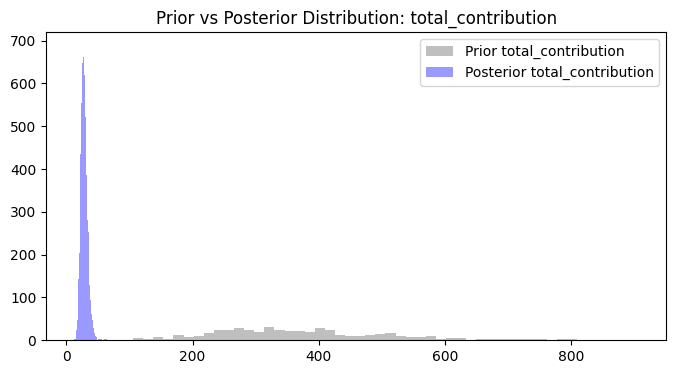

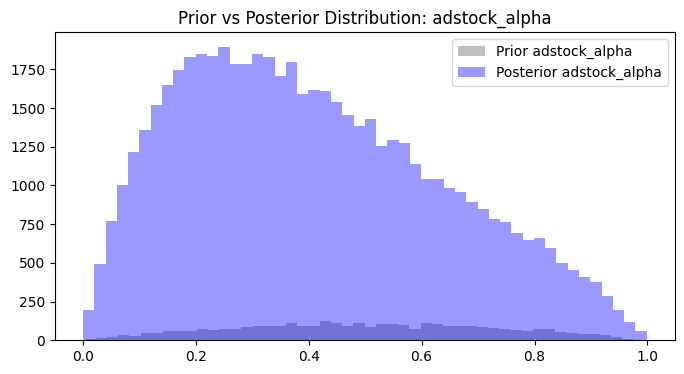

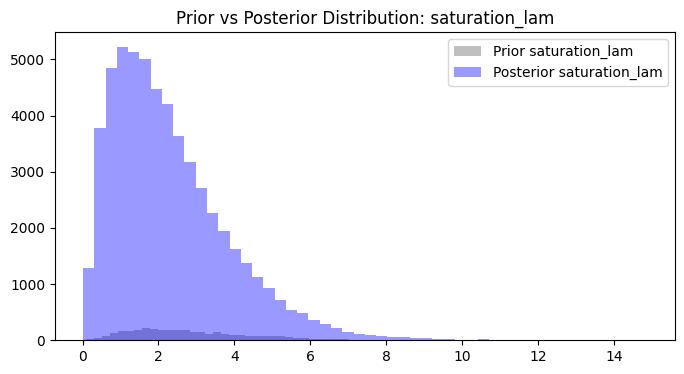

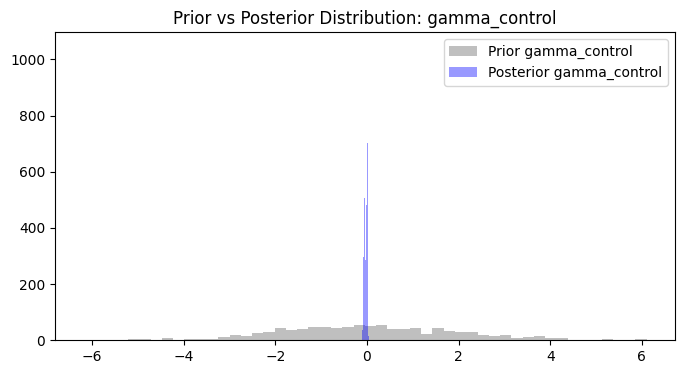

In [65]:
param_names = ['total_contribution', 'adstock_alpha', 'saturation_lam','gamma_control']
# Plot prior vs posterior distributions for scalar params
for param in param_names:
    prior_samples = trace.prior[param].values.flatten()
    posterior_samples = trace.posterior[param].values.flatten()
    plt.figure(figsize=(8, 4))
    plt.hist(prior_samples, bins=50, alpha=0.5, label=f'Prior {param}', color='grey')
    plt.hist(posterior_samples, bins=50, alpha=0.4, label=f'Posterior {param}', color='blue')
    plt.title(f'Prior vs Posterior Distribution: {param}')
    plt.legend()
    plt.show()

In [75]:
with mmm_model.model:
    posterior_predictive = pm.sample_posterior_predictive(trace)


Output()

In [77]:
print(posterior_predictive)

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data


In [87]:
print(list(posterior_predictive.posterior_predictive.data_vars))


['y']


In [88]:
y_pred_samples = posterior_predictive.posterior_predictive['y'].values


In [89]:
y_pred_flat = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])

In [90]:
pred_mean = y_pred_flat.mean(axis=0)
pred_lower = np.percentile(y_pred_flat, 5, axis=0)
pred_upper = np.percentile(y_pred_flat, 95, axis=0)

y_true = df_mmm['y'].values

In [91]:
y_min = df_mmm['y'].min()
y_max = df_mmm['y'].max()

# Transform predicted means back to original scale
pred_mean_raw = pred_mean * (y_max - y_min) + y_min
pred_lower_raw = pred_lower * (y_max - y_min) + y_min
pred_upper_raw = pred_upper * (y_max - y_min) + y_min

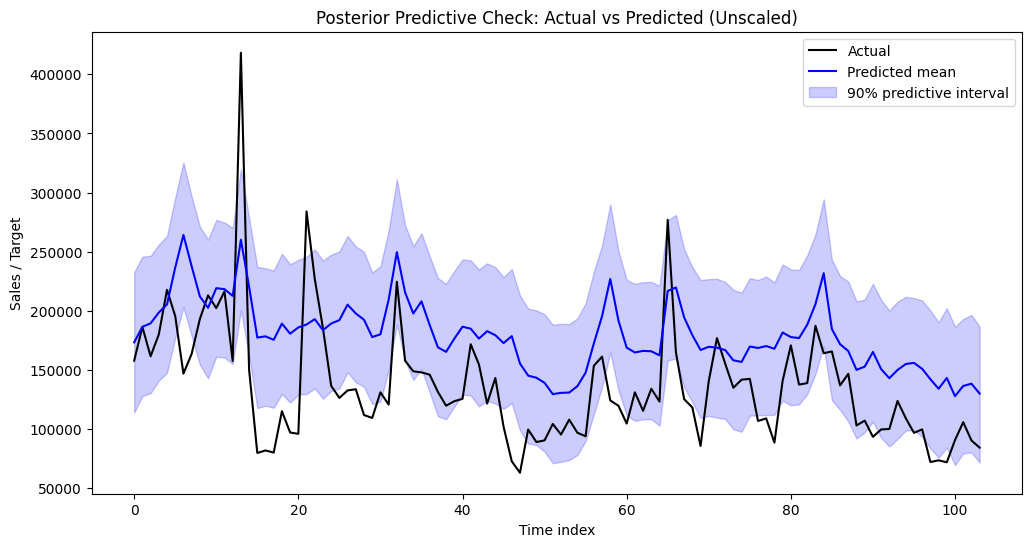

Posterior Predictive RMSE (unscaled): 57214.95
Fraction of observed data within 90% predictive interval: 61.54%


In [93]:
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual', color='black')
plt.plot(pred_mean_raw, label='Predicted mean', color='blue')
plt.fill_between(
    np.arange(len(y_true)),
    pred_lower_raw,
    pred_upper_raw,
    color='blue',
    alpha=0.2,
    label='90% predictive interval'
)
plt.xlabel('Time index')
plt.ylabel('Sales / Target')
plt.title('Posterior Predictive Check: Actual vs Predicted (Unscaled)')
plt.legend()
plt.show()

rmse = np.sqrt(np.mean((pred_mean_raw - y_true) ** 2))
print(f"Posterior Predictive RMSE (unscaled): {rmse:.2f}")

coverage = np.mean((y_true >= pred_lower_raw) & (y_true <= pred_upper_raw))
print(f"Fraction of observed data within 90% predictive interval: {coverage:.2%}")
